In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, style
import seaborn as sns
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix
import itertools

style.use('ggplot')
np.random.seed(42)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [2]:
dataset = pd.read_csv('../data/creditcard/creditcard.csv')

dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)
normal = dataset[dataset['Class'] == 0]

anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(284315, 31)
(492, 31)


In [4]:
from sklearn.model_selection import train_test_split

train, normal_test = train_test_split(normal, test_size=0.2, random_state=42)
normal_valid, normal_test = train_test_split(normal_test, test_size=0.5, random_state=42)
anormal_valid, anormal_test = train_test_split(anomaly, test_size=0.5, random_state=42)

train = train.reset_index(drop=True)
valid = pd.concat([normal_valid, anormal_valid]).sample(frac=1).reset_index(drop=True)
test = pd.concat([normal_test, anormal_test]).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion of anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion of anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape: ', test.shape)
print('Proportion of anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (227452, 31)
Proportion of anomaly in training set: 0.00

Valid shape:  (28677, 31)
Proportion of anomaly in validation set: 0.01

Test shape:  (28678, 31)
Proportion of anomaly in test set: 0.01



In [5]:
from scipy.stats import multivariate_normal

mu = train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

print(np.median(model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values)))
print(np.median(model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values)))

-32.8190882887133
-661.9006173762159


In [6]:
tresholds = np.linspace(-1000, -10, 150)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7493956486704271 110


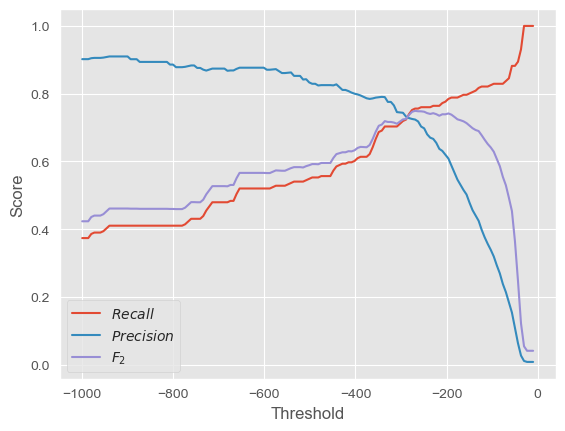

In [7]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -269
Test Recall Score: 0.793
Test Precision Score: 0.701
Test F2 Score: 0.773


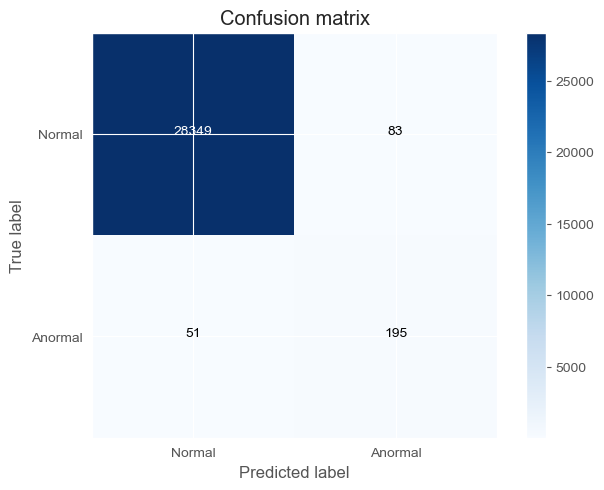

In [8]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.logpdf(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Anormal'], title='Confusion matrix')

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt yo

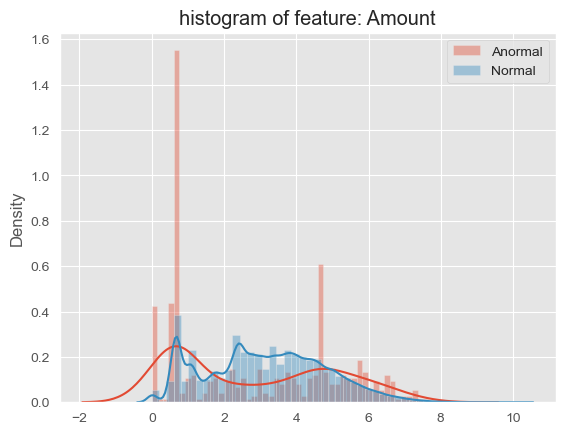

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt yo

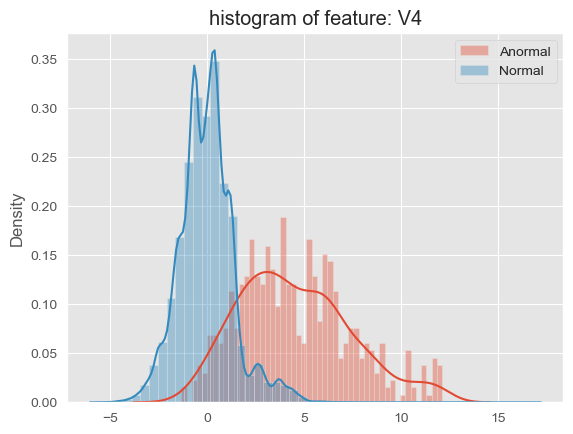

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt yo

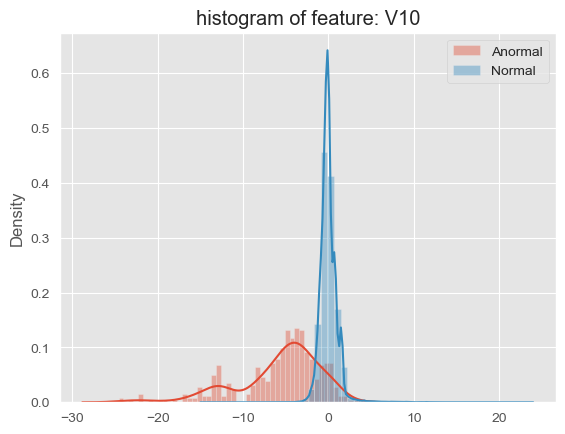

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt yo

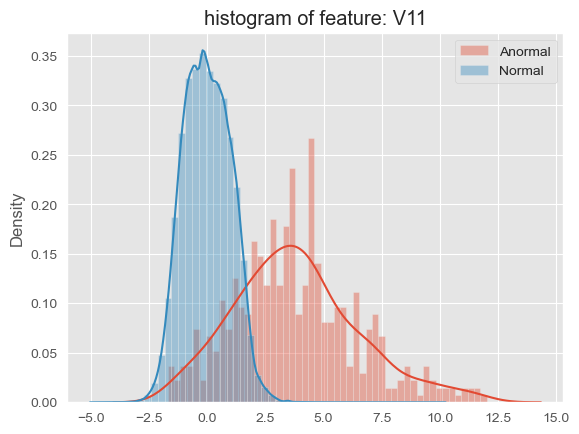

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_43156/1632598823.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt yo

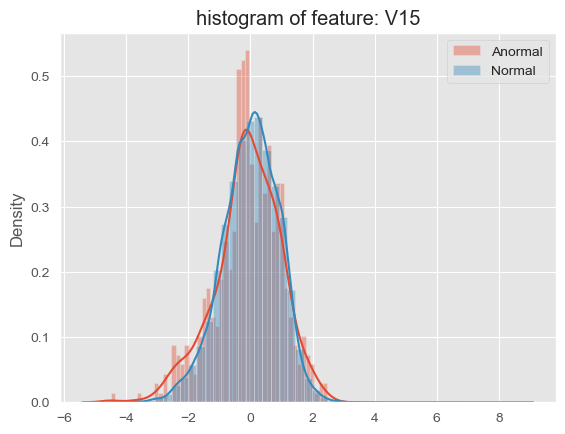

In [9]:
import matplotlib.gridspec as gridspec

for feature in ['Amount', 'V4', 'V10', 'V11', 'V15']:
    ax = plt.subplot()
    sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
    sns.distplot(dataset[feature][dataset.Class == 0], bins=50, label='Normal')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

In [10]:
class hist_model(object):
    def __init__(self, bins=50):
        self.bins = bins

    def fit(self, X):

        bin_hight, bin_edge = [], []

        for var in X.T:
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)

        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)

    def predict(self, X):
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                bin_num = (var > self.bin_edge[i]).argmin() - 1
                obs_score.append(self.bin_hight[i, bin_num])

            scores.append(np.mean(obs_score))

        return np.array(scores)


model = hist_model()
model.fit(train.drop('Class', axis=1).values)
print(np.median(model.predict(valid[valid['Class'] == 0].drop('Class', axis=1).values)))
print(np.median(model.predict(valid[valid['Class'] == 1].drop('Class', axis=1).values)))

67667.86666666667
30645.86666666667


In [11]:
tresholds = np.linspace(10000, 80000, 100)
scores = []
y_pred_score = model.predict(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_hat = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)

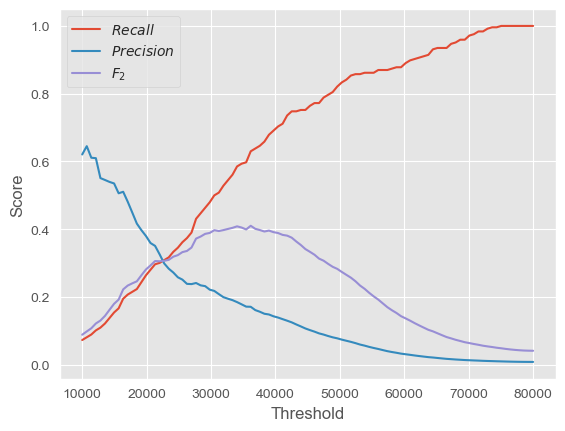

In [12]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: 36161
Test Recall Score: 0.646
Test Precision Score: 0.170
Test F2 Score: 0.415


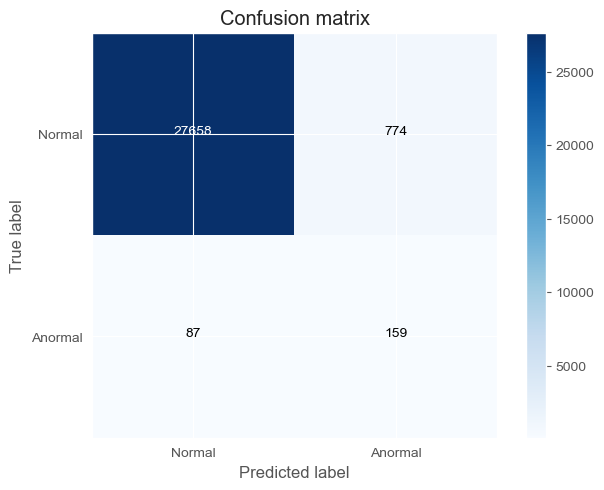

In [13]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Anormal'], title='Confusion matrix')

In [14]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=42)
gmm.fit(train.drop('Class', axis=1).values)
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

8.671669527746152
-67050.35652559673


In [15]:
tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.8004827031375704 74


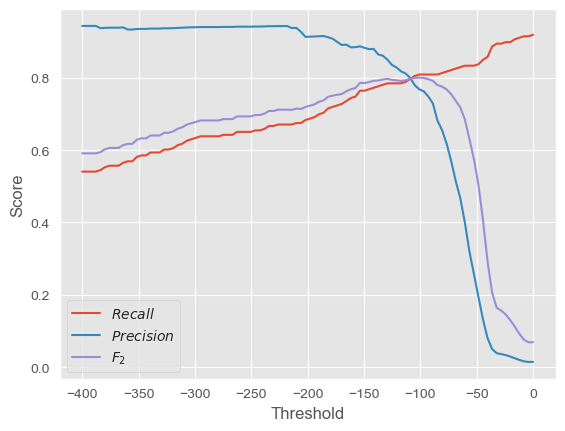

In [16]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -101.010101
Test Recall Score: 0.809
Test Precision Score: 0.726
Test F2 Score: 0.791


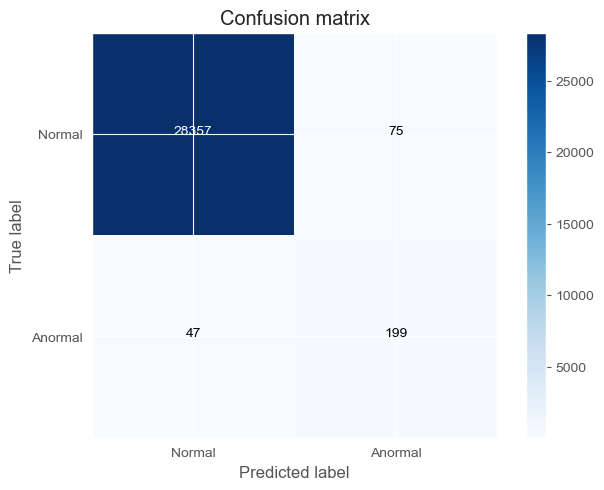

In [17]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Anormal'], title='Confusion matrix')

In [18]:
from sklearn.ensemble import IsolationForest

np.random.seed(42)

model = IsolationForest(random_state=42, n_jobs=4, max_samples=train.shape[0], bootstrap=True, n_estimators=50)
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

0.1501582844248356
-0.05348996832288196


In [19]:
tresholds = np.linspace(-.2, .2, 200)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.6756756756756757 118


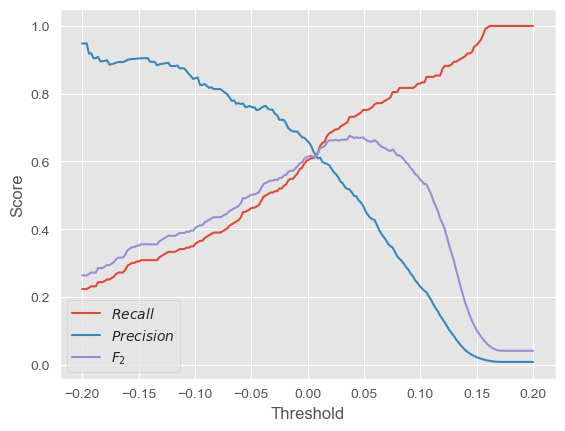

In [20]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: 0.037186
Test Recall Score: 0.736
Test Precision Score: 0.523
Test F2 Score: 0.680


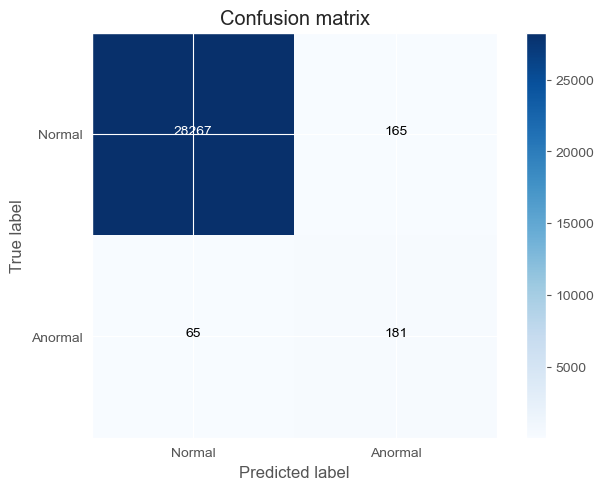

In [21]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Anormal'], title='Confusion matrix')

In [22]:
import tensorflow as tf

tf.reset_default_graph()
tf.set_random_seed(2)

batch_size = 10000

n_visible = train.drop('Class', axis=1).values.shape[1]
n_hidden1 = 27
n_hidden2 = 16
n_hidden3 = 2

learning_rate = 0.01

X_tf = tf.placeholder("float", [None, n_visible], name='X')

W1_init = 4 * np.sqrt(6. / (n_visible + n_hidden1))
W2_init = 4 * np.sqrt(6. / (n_hidden1 + n_hidden2))
W3_init = 4 * np.sqrt(6. / (n_hidden2 + n_hidden3))

W1 = tf.Variable(tf.random_uniform([n_visible, n_hidden1], minval=-W1_init, maxval=W1_init), name='W1')
b1 = tf.Variable(tf.zeros([n_hidden1]), name='b1')

W2 = tf.Variable(tf.random_uniform([n_hidden1, n_hidden2], minval=-W2_init, maxval=W2_init), name='W2')
b2 = tf.Variable(tf.zeros([n_hidden2]), name='b2')

W3 = tf.Variable(tf.random_uniform([n_hidden2, n_hidden3], minval=-W3_init, maxval=W3_init), name='W3')
b3 = tf.Variable(tf.zeros([n_hidden3]), name='b3')

W3_prime = tf.Variable(tf.random_uniform([n_hidden3, n_hidden2], minval=-W3_init, maxval=W3_init), name='W3_prime')
b3_prime = tf.Variable(tf.zeros([n_hidden2]), name='b3_prime')

W2_prime = tf.Variable(tf.random_uniform([n_hidden2, n_hidden1], minval=-W2_init, maxval=W2_init), name='W2_prime')
b2_prime = tf.Variable(tf.zeros([n_hidden1]), name='b2_prime')

W1_prime = tf.Variable(tf.random_uniform([n_hidden1, n_visible], minval=-W1_init, maxval=W1_init), name='W1_prime')
b1_prime = tf.Variable(tf.zeros([n_visible]), name='b1_prime')


def autoencoder(X_tf):
    Y = tf.nn.tanh(tf.matmul(X_tf, W1) + b1)
    Y = tf.nn.tanh(tf.matmul(Y, W2) + b2)
    Y = tf.nn.tanh(tf.matmul(Y, W3) + b3)

    Z = tf.nn.tanh(tf.matmul(Y, W3_prime) + b3_prime)
    Z = tf.nn.tanh(tf.matmul(Z, W2_prime) + b2_prime)
    Z = tf.nn.tanh(tf.matmul(Z, W1_prime) + b1_prime)

    return Z, Y


Z, Y = autoencoder(X_tf)

cost = tf.reduce_mean(tf.pow(X_tf - Z, 2))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
scores = tf.abs(X_tf - Z)

X_train = train.drop('Class', axis=1).values
X_val_norm = valid[valid['Class'] == 0].drop('Class', axis=1).values
X_val_anorm = valid[valid['Class'] == 1].drop('Class', axis=1).values

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [23]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for step in range(15001):
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]

        sess.run(train_op, feed_dict={X_tf: batch_data, })

        if (step % 3000 == 0):
            print('\nBatch loss at step %d: %f' % (step, sess.run(cost, feed_dict={X_tf: batch_data})))
            print('Val Norm loss at step %d: %f' % (step, sess.run(cost, feed_dict={X_tf: X_val_norm})))
            print('Val Anorm loss at step %d: %f' % (step, sess.run(cost, feed_dict={X_tf: X_val_anorm})))

    y_scores_valid, enc_val = sess.run([scores, Y], feed_dict={X_tf: valid.drop('Class', axis=1).values})
    y_scores_test, enc_test = sess.run([scores, Y], feed_dict={X_tf: test.drop('Class', axis=1).values})

AttributeError: module 'tensorflow' has no attribute 'Session'

In [24]:
tresholds = np.linspace(0, 6, 100)

scores = []
for treshold in tresholds:
    y_hat = (y_scores_valid.mean(axis=1) > treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

NameError: name 'y_scores_valid' is not defined

In [25]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [26]:
plt.scatter(enc_val[:, 0], enc_val[:, 1], c=valid["Class"].values, alpha=.5)
plt.show()

NameError: name 'enc_val' is not defined

In [27]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (y_scores_test.mean(axis=1) > final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Anormal'], title='Confusion matrix')

TypeError: list indices must be integers or slices, not tuple